# PystackReg

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# suppress info and warn TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys

sys.path.insert(0, '../')

import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [3]:
from modules.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    std = video[0].std()
    print('calculated std')
    low = np.quantile(video[0], q=0.01)
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [4]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
]

warped_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

## Timings

In [5]:
import time
from pystackreg import StackReg

N = 100

img = tiff.imread(orig_examples[1], key=range(N))
print('image shape:', img.shape)

sr = StackReg(StackReg.AFFINE)

# register each frame to the previous (already registered) one
# this is what the original StackReg ImageJ plugin uses
t1 = time.perf_counter()
out = sr.register_transform_stack(img, reference='first')
t2 = time.perf_counter()
print(f'Transformation completed in {t2-t1:.3f}s | {(t2-t1)/N:.3f}s per frame')

image shape: (100, 480, 736)
Transformation completed in 27.239s | 0.272s per frame


In [9]:
make_video('orig', frame_gen(img))
make_video('warped-first', frame_gen(out))

calculated std


100it [00:00, 219.12it/s]


converting video..
Done (0.90s)
calculated std


100it [00:00, 219.83it/s]


converting video..
Done (0.86s)


In [7]:
Video('orig.mov')

In [10]:
Video('warped-first.mov')

## Example

In [5]:
image = tiff.imread('../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/red.pystackreg.tif')
print('image shape:', image.shape)
make_video('out', frame_gen(image))
del image

image shape: (4100, 480, 736)
calculated std and mean


4100it [00:18, 216.84it/s]


converting video..
Done (28.29s)


In [6]:
Video('out.mov')

### Centers metric

In [7]:
from modules.metrics import get_centers, failure_score

image shape: (4100, 480, 736)
x: 209.63 + 1.18
y: 365.47 + 2.09
failures: 0
failure score: 0.00%


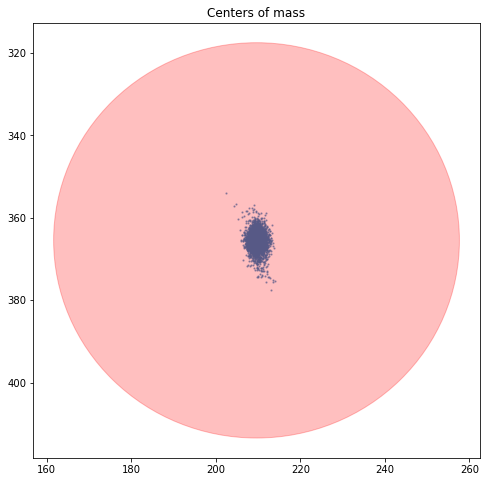

In [9]:
try:
    del image
except Exception:
    pass
image = tiff.imread('../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/red.pystackreg.tif')
print('image shape:', image.shape)

centers = get_centers(image)

m_centers = centers.mean(axis=0)
s_centers = centers.std(axis=0)
print(f'x: {m_centers[0]:.2f} + {s_centers[0]:.2f}')
print(f'y: {m_centers[1]:.2f} + {s_centers[1]:.2f}')

score, failures = failure_score(image)
print('failures:', sum(failures))
print(f'failure score: {score * 100:.2f}%')

plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
circ = plt.Circle(m_centers, 0.1 * min(*image.shape[1:]), color='r', alpha=.25)
ax.add_patch(circ)
ax.scatter(centers[:, 0], centers[:, 1], s=1.5, alpha=0.5)
lx, ly = ax.get_xlim()[0], ax.get_ylim()[0]
dx = ax.get_xlim()[1] - lx
dy = ax.get_ylim()[1] - ly
dmax = max(dx, dy)
ax.set_xlim(lx, lx + dmax); ax.set_ylim(ly + dmax, ly);
plt.title(r'Centers of mass')
plt.show()

## Repeated pystackreg

In [27]:
import time
from pystackreg import StackReg
from modules.metrics import MSE_score

N = 60
nb_reps = 20

img = tiff.imread(orig_examples[1], key=range(N))
ref_score = MSE_score(img)
print('image shape:', img.shape, f'ref score: {ref_score:,.0f}')

sr = StackReg(StackReg.AFFINE)

# register each frame to the previous (already registered) one
# this is what the original StackReg ImageJ plugin uses
t1 = time.perf_counter()
out = img
for k in range(nb_reps):
    out = sr.register_transform_stack(out, reference='first')

    score = MSE_score(out)
    print(f'Repetitions: {k+1:3d} | ref: {ref_score:,.0f} | score: {score:,.0f}')    
t2 = time.perf_counter()
print(f'Repetitions {nb_reps}: Transformation completed in {t2-t1:.3f}s | {(t2-t1)/N:.3f}s per frame')

image shape: (60, 480, 736) ref score: 4,685,316
Repetitions:   1 | ref: 4,685,316 | score: 2,478,426
Repetitions:   2 | ref: 4,685,316 | score: 2,255,655
Repetitions:   3 | ref: 4,685,316 | score: 2,180,286
Repetitions:   4 | ref: 4,685,316 | score: 2,092,864
Repetitions:   5 | ref: 4,685,316 | score: 2,074,347
Repetitions:   6 | ref: 4,685,316 | score: 2,004,141
Repetitions:   7 | ref: 4,685,316 | score: 2,007,761
Repetitions:   8 | ref: 4,685,316 | score: 1,950,840
Repetitions:   9 | ref: 4,685,316 | score: 1,979,822
Repetitions:  10 | ref: 4,685,316 | score: 1,916,178
Repetitions:  11 | ref: 4,685,316 | score: 1,957,659
Repetitions:  12 | ref: 4,685,316 | score: 1,905,180
Repetitions:  13 | ref: 4,685,316 | score: 1,942,654
Repetitions:  14 | ref: 4,685,316 | score: 1,890,098
Repetitions:  15 | ref: 4,685,316 | score: 1,927,738
Repetitions:  16 | ref: 4,685,316 | score: 1,876,942
Repetitions:  17 | ref: 4,685,316 | score: 1,928,127
Repetitions:  18 | ref: 4,685,316 | score: 1,872,7

In [ ]:
make_video(f'pysreg-{nb_reps}reps', frame_gen(out))
Video(f'pysreg-{nb_reps}reps.mov')